In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
import time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(" Libraries imported successfully!")
print(f" XGBoost version: {xgb.__version__}")

 Libraries imported successfully!
 XGBoost version: 2.0.3


### 1. Load Processed Data

In [2]:
train_processed = pd.read_csv('../data/processed/train_processed.csv')

print("Data Loading")
print("=" * 80)
print(f"\n Dataset shape: {train_processed.shape}")
print(f" Number of features: {train_processed.shape[1] - 2}")  # Excluding unit_id and RUL
print(f" Target variable: RUL (Remaining Useful Life)")

print("\n First few rows:")
display(train_processed.head())

Data Loading

 Dataset shape: (20631, 113)
 Number of features: 111
 Target variable: RUL (Remaining Useful Life)

 First few rows:


,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_9,...,sensor_2_lag_5,sensor_3_lag_1,sensor_3_lag_2,sensor_3_lag_5,sensor_4_lag_1,sensor_4_lag_2,sensor_4_lag_5,stage_early,stage_mid,stage_late
0,1,-1.565170,-0.315980,-1.372953,0.0,-1.721725,-0.134255,-0.925936,1.121141,-0.862813,...,-1.737067,-0.122526,-0.110816,-0.074472,-0.922252,-0.917567,-0.903493,True,False,False
1,1,-1.550652,0.872722,-1.031720,0.0,-1.061780,0.211528,-0.643726,0.431930,-0.958818,...,-1.737067,-0.122526,-0.110816,-0.074472,-0.922252,-0.917567,-0.903493,True,False,False
2,1,-1.536134,-1.961874,1.015677,0.0,-0.661813,-0.413166,-0.525953,1.008155,-0.557139,...,-1.737067,0.226063,-0.110816,-0.074472,-0.636438,-0.917567,-0.903493,True,False,False
3,1,-1.521616,0.324090,-0.008022,0.0,-0.661813,-1.261314,-0.784831,1.222827,-0.713826,...,-1.737067,-0.403700,0.240492,-0.074472,-0.517161,-0.628663,-0.903493,True,False,False
4,1,-1.507098,-0.864611,-0.690488,0.0,-0.621816,-1.251528,-0.301518,0.714393,-0.457059,...,-1.737067,-1.258731,-0.394183,-0.074472,-0.779345,-0.508097,-0.903493,True,False,False


### 2. Prepare Data for Modeling

#### Train test Split Strategy
 - In time-series we can't use random split
 - Split by engine ID (no data leakage)

In [8]:
print("Data Preparation")

print(f"Rows before dropna: {len(train_processed)}")
train_processed = train_processed.dropna().reset_index(drop=True)
print(f"Rows after dropna: {len(train_processed)}")

feature_cols = [col for col in train_processed.columns if col not in ['unit_id', 'RUL']]
X = train_processed[feature_cols]
y = train_processed['RUL']
unit_ids = train_processed['unit_id']

print(f"\n Feature matrix shape: {X.shape}")
print(f" Target vector shape: {y.shape}")

unique_engines = train_processed['unit_id'].unique()
n_train_engines = int(len(unique_engines) * 0.8)

train_engines = unique_engines[:n_train_engines]
test_engines = unique_engines[n_train_engines:]

train_mask = train_processed['unit_id'].isin(train_engines)
test_mask = train_processed['unit_id'].isin(test_engines)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\n Train-Test Split Complete:")
print(f"   - Training engines: {len(train_engines)} ({len(X_train)} samples)")
print(f"   - Testing engines: {len(test_engines)} ({len(X_test)} samples)")
print(f"   - Split ratio: {len(X_train) / len(X) * 100:.1f}% train / {len(X_test) / len(X) * 100:.1f}% test")

overlap = set(train_engines) & set(test_engines)
print(f"\n Data leakage check: {' FAILED' if overlap else ' PASSED'}")
if overlap:
    print(f"   Overlapping engines: {overlap}")

Data Preparation
Rows before dropna: 20631
Rows after dropna: 20531

 Feature matrix shape: (20531, 111)
 Target vector shape: (20531,)

 Train-Test Split Complete:
   - Training engines: 80 (16058 samples)
   - Testing engines: 20 (4473 samples)
   - Split ratio: 78.2% train / 21.8% test

 Data leakage check:  PASSED


### Define Evaluation Matrix

Calculate all evaluation metrics for a model.
    
    Key Concepts:
    - Underestimated RUL (y_pred < y_true): Model predicts failure SOONER -> Early maintenance (SAFE)
    - Overestimated RUL (y_pred > y_true): Model predicts failure LATER -> Late maintenance (DANGEROUS)

In [13]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    errors = y_pred - y_true
    underestimated_rul = errors < 0 
    overestimated_rul = errors > 0 

    overestimation_penalty = np.sum(np.abs(errors[overestimated_rul]) * 2)
    underestimation_penalty = np.sum(np.abs(errors[underestimated_rul]))
    asymmetric_score = (overestimation_penalty + underestimation_penalty) / len(y_true)
    
    results = {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'asymmetric_score': asymmetric_score,
        'overestimated_pct': (overestimated_rul.sum() / len(y_true)) * 100,
        'underestimated_pct': (underestimated_rul.sum() / len(y_true)) * 100
    }
    
    return results

def print_results(results):
    print(f"{results['model'].upper()} PERFORMANCE")
    print(f"\n Standard Metrics:")
    print(f"   - RMSE: {results['rmse']:.2f} cycles")
    print(f"   - MAE:  {results['mae']:.2f} cycles")
    print(f"   - R²:   {results['r2']:.4f}")
    print(f"\n Business Metrics:")
    print(f"   - Asymmetric Score: {results['asymmetric_score']:.2f}")
    print(f"     (Penalizes overestimation 2x more than underestimation)")
    
    print(f"\n Prediction Breakdown:")
    print(f"    Underestimated RUL (Safe):     {results['underestimated_pct']:.1f}%")
    print(f"      -> Predicts failure sooner -> Early maintenance")
    print(f"    Overestimated RUL (Risky):    {results['overestimated_pct']:.1f}%")
    print(f"      -> Predicts failure later -> Potential missed failures")
    print(f"\n Interpretation:")
    if results['rmse'] < 15:
        print(f"    Excellent: Very accurate predictions!")
    elif results['rmse'] < 25:
        print(f"    Good: Acceptable for production")
    else:
        print(f"    Needs improvement")
    
    if results['late_predictions_pct'] < 30:
        print(f"    Low risk: Few dangerous late predictions")
    else:
        print(f"    High risk: Many late predictions")

print(" Evaluation functions defined!")

 Evaluation functions defined!


### 4. Model 1: Baseline - Linear Regression

In [12]:
print("Model 1: Linear Regression (Baseline)")
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred_lr = lr_model.predict(X_test)

lr_results = evaluate_model(y_test, y_pred_lr, "Linear Regression")
lr_results['training_time'] = training_time

print(lr_results)
print(f"\n Training time: {training_time:.3f} seconds")

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': np.abs(lr_model.coef_)
}).sort_values('coefficient', ascending=False)

print(f"\n Top 10 Most Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:50s} {row['coefficient']:8.4f}")

Model 1: Linear Regression (Baseline)
{'model': 'Linear Regression', 'rmse': 6.810508410909662, 'mae': 5.406917531938594, 'r2': 0.972814630974583, 'asymmetric_score': 8.236884843948674, 'overestimated_pct': 57.70176615247038, 'underestimated_pct': 42.29823384752962, 'training_time': 0.13715052604675293}

 Training time: 0.137 seconds

 Top 10 Most Important Features:
   sensor_3                                           313062004198.0842
   sensor_3_lag_1                                     310541949290.8635
   sensor_3_rate_of_change                            288178428957.0363
   op_setting_3                                       208524029457.8590
   stage_mid                                          173524565553.4612
   stage_late                                         173524565548.0089
   stage_early                                        173524565547.5509
   sensor_2_rolling_mean_5                            113528817439.5237
   sensor_4_cumsum                                    

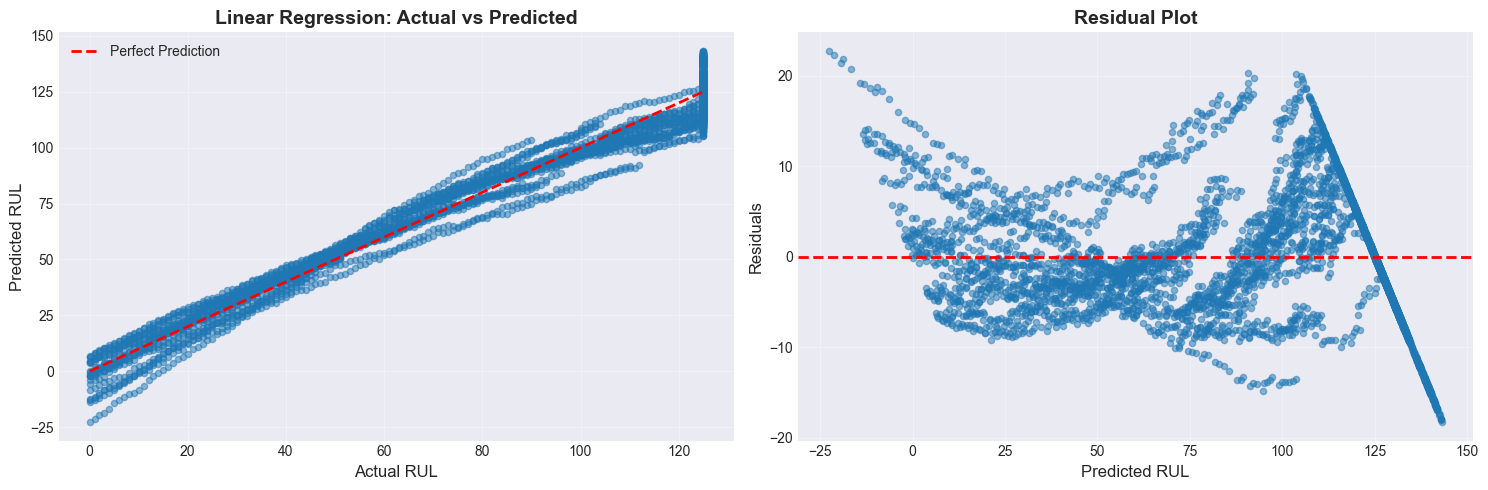


 What to look for:
   - Left plot: Points should be on red line (perfect predictions)
   - Right plot: Residuals should be randomly scattered around 0
   - Patterns in residuals indicate model can be improved


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_test, y_pred_lr, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL', fontsize=12)
axes[0].set_ylabel('Predicted RUL', fontsize=12)
axes[0].set_title('Linear Regression: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_lr
axes[1].scatter(y_pred_lr, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted RUL', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n What to look for:")
print("   - Left plot: Points should be on red line (perfect predictions)")
print("   - Right plot: Residuals should be randomly scattered around 0")
print("   - Patterns in residuals indicate model can be improved")

### 5. Model 2: Random Forest

In [16]:
print("Model 2: Random Forest")

print("\n Training Random Forest...")
start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred_rf = rf_model.predict(X_test)

rf_results = evaluate_model(y_test, y_pred_rf, "Random Forest")
rf_results['training_time'] = training_time

print(rf_results)
print(f"\n Training time: {training_time:.2f} seconds")

feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n Top 10 Most Important Features:")
for idx, row in feature_importance_rf.head(10).iterrows():
    print(f"   {row['feature']:50s} {row['importance']:8.4f}")

Model 2: Random Forest

 Training Random Forest...
{'model': 'Random Forest', 'rmse': 5.708626008786092, 'mae': 3.9684532112473034, 'r2': 0.9808997369183396, 'asymmetric_score': 5.123917686687045, 'overestimated_pct': 27.96780684104628, 'underestimated_pct': 71.45092778895595, 'training_time': 4.973376989364624}

 Training time: 4.97 seconds

 Top 10 Most Important Features:
   cycles_remaining                                     0.1922
   cycle_ratio                                          0.1175
   stage_late                                           0.0783
   sensor_2_rolling_mean_10                             0.0770
   sensor_4_rolling_mean_10                             0.0537
   sensor_2_rolling_mean_20                             0.0498
   sensor_3_rolling_mean_10                             0.0344
   time_cycles                                          0.0313
   sensor_4_rolling_mean_20                             0.0293
   sensor_3_rolling_mean_20                            

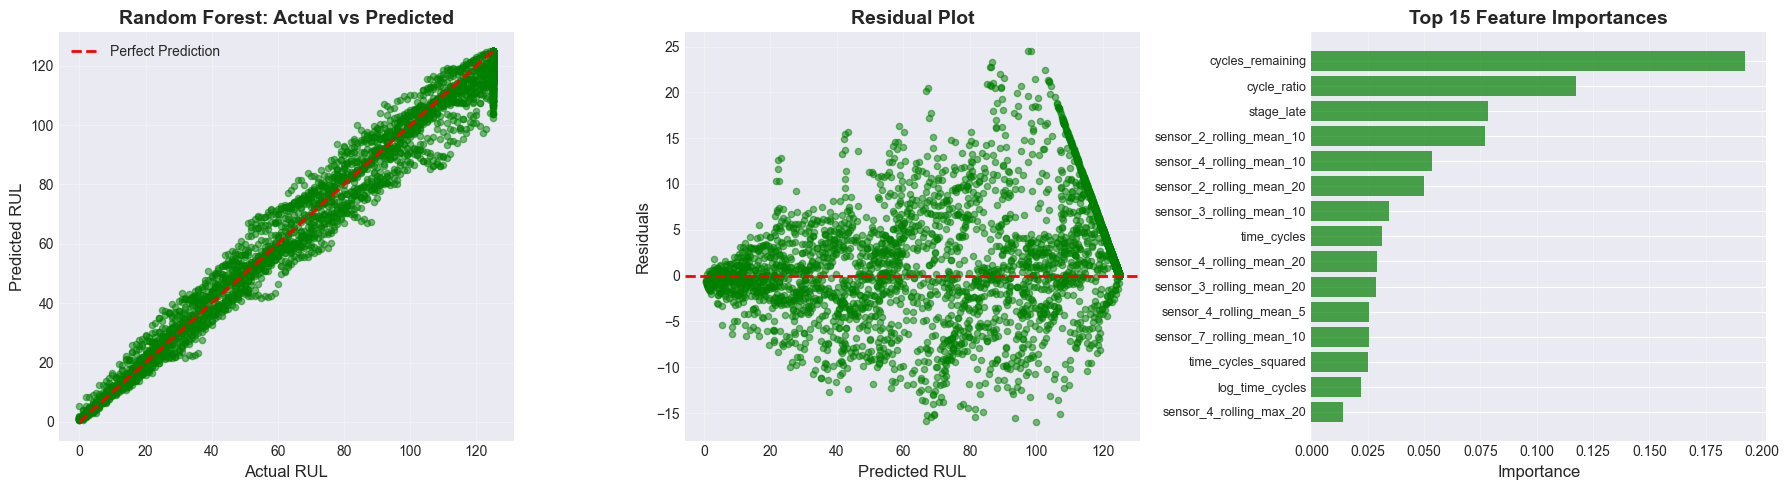

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test, y_pred_rf, alpha=0.5, s=20, c='green')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL', fontsize=12)
axes[0].set_ylabel('Predicted RUL', fontsize=12)
axes[0].set_title('Random Forest: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals_rf = y_test - y_pred_rf
axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.5, s=20, c='green')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted RUL', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

top_features = feature_importance_rf.head(15)
axes[2].barh(range(len(top_features)), top_features['importance'], color='green', alpha=0.7)
axes[2].set_yticks(range(len(top_features)))
axes[2].set_yticklabels([f[:30] for f in top_features['feature']], fontsize=9)
axes[2].set_xlabel('Importance', fontsize=12)
axes[2].set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()